In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Import data
#path = r'C:\Users\Marcus\Downloads'
path = os.getcwd()
print("Current directory: ", path)
y = np.genfromtxt(path + '/seOMXlogreturns2012to2014.csv')

# Static parameters
phi = 0.98
sigma = 0.16
Beta = [0.5, 0.75, 1.0, 1.5, 2.0, 2.25] # Vary beta between 0 and 2

Current directory:  C:\Users\Marcus\workspace\smc_methods


## P1: Likelihood estimates for the stochastic volatility model

In [15]:
def bootstrap_particle_filter(y, n_particles, theta, resampling=True):
    # Static parameters
    phi = theta[0] 
    sigma = theta[1] 
    beta = theta[2]
    
    # Initilialization
    T = len(y)
    logl = 0.0
    x = np.random.normal(0.0, sigma, size=n_particles)
    w = np.ones(n_particles) / n_particles
    
    X = np.zeros([T+1, n_particles])
    X[0, :] = x
    W = np.zeros([T+1, n_particles])
    W[0, :] = w
    #W_tilde = np.zeros([T, n_particles])
    
    for t in range(T):
        
        if resampling:
            # Resample directly without saving ancestor indices
            x = np.random.choice(x, n_particles, p=w)
            
        x = np.random.normal(loc=phi*x, scale=sigma)
        log_w_tilde = norm.logpdf(y[t], loc=0.0, scale=beta * np.exp(x / 2) )
        # Compute log-liklihood with logsumexp trick
        max_w_tilde = np.max(log_w_tilde)
        logl += max_w_tilde + np.log(np.sum(np.exp(log_w_tilde - max_w_tilde))) - np.log(n_particles)
        
        w = np.exp(log_w_tilde - max_w_tilde) / np.sum(np.exp(log_w_tilde - max_w_tilde))                          
        
        X[t+1, :] = x
        W[t+1, :] = w
        #W_tilde[t, :] = w_tilde
    return X, W, logl

beta:  0.5
beta:  0.75
beta:  1.0
beta:  1.5
beta:  2.0
beta:  2.25


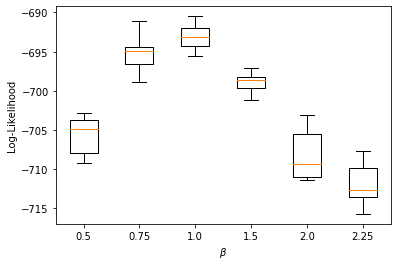

In [28]:
n_runs = 10
logl_list = []

N = 100

for i, beta in enumerate(Beta):
    #print("beta: ", beta)
    theta = [phi, sigma, beta]
    logl_beta = []
    for j in range(n_runs):
        x, w, logl = bootstrap_particle_filter(y, N, theta)
        #print("logl: ", logl)
        logl_beta.append(logl)
    logl_list.append(logl_beta)

# Plot boxplot
beta_list = [str(b) for b in Beta]
plt.boxplot(logl_list, showfliers=False, labels=beta_list)
plt.xlabel(r"$\beta$"); plt.ylabel("Log-Likelihood"); 
plt.show()

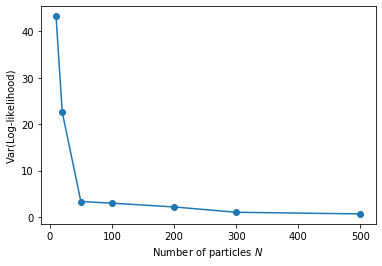

In [39]:
T = len(y)
n_runs = 10
logl_var = []
N = [10, 20, 50, 100, 200, 300, 500]
beta = 1.0
for i, n_particles in enumerate(N):
    theta = [phi, sigma, beta]
    logl_N = []
    for j in range(n_runs):
        x, w, logl = bootstrap_particle_filter(y, n_particles, theta)
        logl_N.append(logl)
    logl_var.append(np.var(logl_N))
# Plot variance of log-likelihood estimate over number of particles
plt.plot(N, logl_var, 'o-')
plt.xlabel("Number of particles $N$"); plt.ylabel("Var(Log-likelihood)")
plt.show()

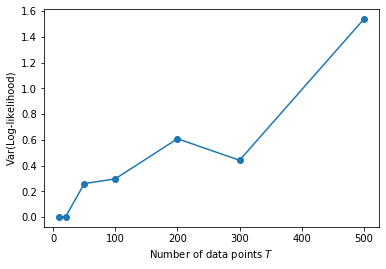

In [46]:
T = len(y)
n_runs = 10
logl_var = []
n_time_steps = [10, 20, 50, 100, 200, 300, 500]
n_particles = 200
beta = 1.0
for i, T in enumerate(n_time_steps):
    theta = [phi, sigma, beta]
    logl_T = []
    for j in range(n_runs):
        x, w, logl = bootstrap_particle_filter(y[:T], n_particles, theta)
        logl_T.append(logl)
    logl_var.append(np.var(logl_T))
# Plot variance of log-likelihood estimate over number of data points (time steps)
plt.plot(N, logl_var, 'o-')
plt.xlabel("Number of data points $T$"); plt.ylabel("Var(Log-likelihood)")
plt.show()

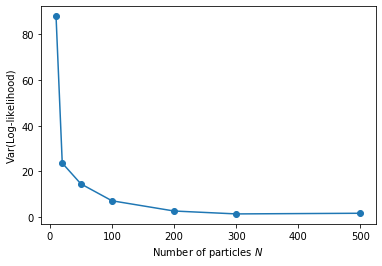

In [45]:
T = len(y)
n_runs = 10
logl_var = []
N = [10, 20, 50, 100, 200, 300, 500]
beta = 1.0
for i, n_particles in enumerate(N):
    theta = [phi, sigma, beta]
    logl_N = []
    for j in range(n_runs):
        x, w, logl = bootstrap_particle_filter(y, n_particles, theta, resampling=False)
        logl_N.append(logl)
    logl_var.append(np.var(logl_N))
# Plot variance of log-likelihood estimate over number of particles
plt.plot(N, logl_var, 'o-')
plt.xlabel("Number of particles $N$"); plt.ylabel("Var(Log-likelihood)")
plt.show()
# Variance of log-likelihood is bigger without resampling

## P2: Fully adapted particle filter

a) Full adaptation is possible whenever (x_t, y_t) are jointly Gaussian conditionally on x_{t-1}. This is the case when the transition density f(x_t | x_{t-1}) is Gaussian and the
measurement model g(y_t | x_t) is linear and Gaussian (page 83).

The SSMs (i) and (ii) have Gaussian noise in both transition density and measurement model. In SSM (iii), the measurement noise is modelled as a uniform distribution, which doesn't make 
the measurement model Gaussian.

In [18]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def generate_data(n):
    y = np.zeros(n)
    x = np.random.normal(0, 1, size=1)
    for i in range(n):
        x = np.cos(x)**2 + np.random.normal(0, 1.0)
        y[i] = 2*x + np.random.normal(0, np.sqrt(0.01) )
    return y

In [19]:
def fully_adapted_particle_filter(y, n_particles):
    # Static parameters
    sigma2_x = 1.0 # Noise variance in dynamics 
    sigma2_y = 0.01 # Noise variance in measurements 
    c = 2.0 
    K = sigma2_x * c / (c**2 * sigma2_x + sigma2_y)
    
    T = len(y)
    
    # Initialization
    x = np.random.normal(0.0, 1.0, size=n_particles)
    w = np.ones(n_particles) / n_particles
    
    X = np.zeros([T+1, n_particles])
    W = np.zeros([T+1, n_particles])
    A = np.zeros([T, n_particles])
    X[0, :] = x
    W[0, :] = w
    
    for t in range(0, T):
        
        # Compute adjustment multipliers using p(y_t | x_{t-1})
        v = norm.pdf(y[t], loc=c*np.cos(x)**2, scale=np.sqrt(c**2 * sigma2_x + sigma2_y) )
        # Resample x with probabilities proportional to w_{t-1}*v_{t-1} 
        resampling_weights = (w * v) / np.sum(w*v)
        ancestors = np.random.choice(n_particles, n_particles, p=resampling_weights)
        x_resampled = x[ancestors]
        
        # Sample x from posterior p(x_t | x_{t-1}, y_t)
        x = np.random.normal(loc=np.cos(x_resampled)**2 + K*(y[t] - c*np.cos(x_resampled)**2 ),
                             scale=np.sqrt((1 - c*K)*sigma2_x) )
        
        # Don't need to update weights, since they are w_tilde is const. -> w = 1/n_particles
        # w = omega(x_resampled, x, y) = p(y | x_resampled) / v(x_resampled, y) = 1
        
        X[t+1, :] = x
        W[t+1, :] = w
        A[t, :] = ancestors
    return X, W, A
    

In [20]:
def bootstrap_particle_filter(y, n_particles, resampling=True):
    # Static parameters
    sigma2_x = 1.0 # Noise variance in dynamics 
    sigma2_y = 0.01 # Noise variance in measurements 
    c = 2.0
    
    # Initilialization
    T = len(y)
    logl = 0.0
    x = np.random.normal(0.0, sigma2_x, size=n_particles)
    w = np.ones(n_particles) / n_particles
    
    X = np.zeros([T+1, n_particles])
    X[0, :] = x
    W = np.zeros([T+1, n_particles])
    W[0, :] = w
    #W_tilde = np.zeros([T, n_particles])
    
    for t in range(T):
        
        if resampling:
            # Resample directly without saving ancestor indices
            x = np.random.choice(x, n_particles, p=w)
            
        x = np.random.normal(loc=np.cos(x)**2, scale=np.sqrt(sigma2_x))
        log_w_tilde = norm.logpdf(y[t], loc=c*x, scale=np.sqrt(sigma2_y) )
        # Compute log-liklihood with logsumexp trick
        max_w_tilde = np.max(log_w_tilde)
        logl += max_w_tilde + np.log(np.sum(np.exp(log_w_tilde - max_w_tilde))) - np.log(n_particles)
        
        w = np.exp(log_w_tilde - max_w_tilde) / np.sum(np.exp(log_w_tilde - max_w_tilde))                          
        
        X[t+1, :] = x
        W[t+1, :] = w
        #W_tilde[t, :] = w_tilde
    return X, W, logl

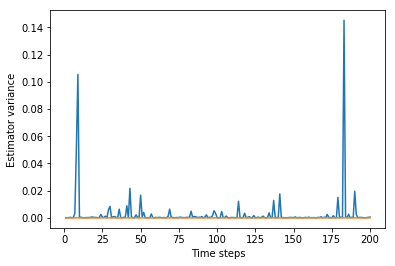

In [33]:
T = 200
y = generate_data(T)
N = 100
n_runs = 10
means_fapf = np.zeros([n_runs, T])
means_bpf = np.zeros([n_runs, T])
for i in range(n_runs):
    # Run particle filters
    x_fapf, w_fapf, _ = fully_adapted_particle_filter(y, N)
    x_bpf, w_bpf, _ = bootstrap_particle_filter(y, N)
    # Compute mean estimates
    means_fapf[i, :] = np.sum(w_fapf[1:, :] * x_fapf[1:, :], axis=1)
    means_bpf[i, :] = np.sum(w_bpf[1:, :] * x_bpf[1:, :], axis=1)

plt.plot(np.linspace(1, T, T), np.var(means_bpf, axis=0), label='Bootstrap PF')
plt.plot(np.linspace(1, T, T), np.var(means_fapf, axis=0), label='Fully-Adapted PF')
plt.xlabel("Time steps"); plt.ylabel("Estimator variance")
plt.show()

## P4: Forgetting

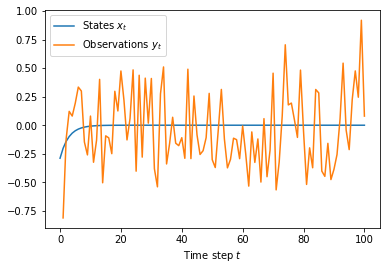

In [15]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

def generate_data(n):
    y = np.zeros(n)
    x = np.zeros(n+1)
    x[0] = np.random.normal(0, 1, size=1)
    for i in range(n):
        x[i+1] = 0.7*x[i] #+ np.random.normal(0, np.sqrt(0.1) )
        y[i] = 0.5*x[i+1] + np.random.normal(0, np.sqrt(0.1) )
    return y, x

T = 100
y, x = generate_data(T)
plt.plot(np.linspace(0, T, T+1), x, label='States $x_t$')
plt.plot(np.linspace(1, T, T), y, label='Observations $y_t$')
plt.xlabel('Time step $t$'); #plt.ylabel('$x_t$')
plt.legend()
plt.show()

In [19]:
def kalman_filter(y, A=0.7, C=0.5, P0=1.0, Q=0.1, R=0.1):
    
    T = len(y)
    
    # Define means and covariances for filtering pdf
    # Filtering mean equal to zero at t=0
    means_filtering = np.zeros(T+1)
    covs_filtering = np.zeros(T+1) # P_{t|t}
    
    # Initialize filtering covariance at t=0 with P0
    covs_filtering[0] = P0
    
    for t in range(T):
        # Covariance for time update pdf denoted as P_{t|t-1}
        cov_time_update = A**2 * covs_filtering[t] + Q
        # Compute Kalman gain K
        L = 1 / (C**2 * cov_time_update + R)
        K = cov_time_update * C * L
        
        # Compute filtering mean and covariance
        means_filtering[t+1] = A * means_filtering[t] + K*(y[t] - A*C*means_filtering[t])
        covs_filtering[t+1] = cov_time_update - K * C * cov_time_update #K**2 * L
        
    return means_filtering, covs_filtering

In [13]:
def bootstrap_particle_filter(y, n_particles, A=0.7, C=0.5, P0=1.0, Q=0.1, R=0.1):
    
    # Initilialization
    T = len(y)
    x = np.zeros([T+1, n_particles])
    x[0, :] = np.random.normal(0.0, P0, size=n_particles)
    w = np.zeros([T+1, n_particles])
    w[0, :] = np.ones(n_particles) / n_particles
    
    for t in range(T):
        
        # Sample ancestor indices
        ancestors = np.random.choice(n_particles, n_particles, p=w[t])
            
        x[t+1, :] = A * x[t, ancestors] + np.sqrt(Q) * np.random.normal(loc=0.0, scale=1.0, size=n_particles)
        # Compute weights using unnormalized log weights
        log_w_tilde = norm.logpdf(y[t], loc=C*x[t+1], scale=np.sqrt(R) )
        max_w_tilde = np.max(log_w_tilde)
        w[t+1, :] = np.exp(log_w_tilde - max_w_tilde) / np.sum(np.exp(log_w_tilde - max_w_tilde))                          
        
    return x, w

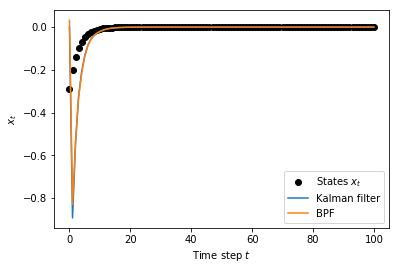

In [21]:
means_kf, covs_kf = kalman_filter(y, Q=0.0)
x_bpf, w_bpf = bootstrap_particle_filter(y, n_particles=500, Q=0.0)
means_bpf = np.sum(x_bpf * w_bpf, axis=1)

plt.plot(x, 'ok', label='States $x_t$')
plt.plot(means_kf, label='Kalman filter')
plt.plot(means_bpf, label='BPF')
plt.xlabel('Time step $t$'); plt.ylabel('$x_t$')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

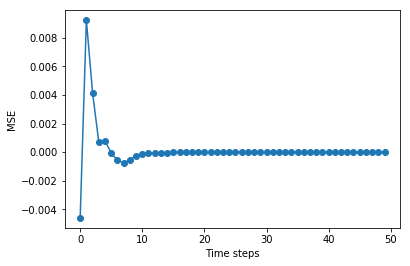

In [35]:
n_runs = 100
means_bpf = np.zeros([n_runs, T+1])

# Run Kalman filter
means_kf, covs_kf = kalman_filter(y, Q=0.0)

mse = 0.0
for i in range(n_runs):
    x_bpf, w_bpf = bootstrap_particle_filter(y, n_particles=500, Q=0.0)
    means_bpf[i, :] = np.sum(x_bpf * w_bpf, axis=1)
    
    mse += (means_bpf[i, :] - means_kf)**2

mse = mse / n_runs

plt.plot(mse[:50], 'o-')
plt.xlabel('Time steps'); plt.ylabel('MSE')
plt.show